In [1]:
!pip install einops mamba_ssm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 7.5 MB/s eta 0:00:00
  Created wheel for mamba_ssm: filename=mamba_ssm-2.2.2-cp310-cp310-linux_x86_64.whl size=323998290 sha256=a658a5438dbe9fb3a53799d7d9f4714ca09225769c24ec04a403728ac7d1c69e
  Stored in directory: /root/.cache/pip/wheels/57/7c/90/9f963468ecc3791e36e388f9e7b4a4e1e3f90fbb340055aa4d
Successfully built mamba_ssm


In [2]:
import os
import glob
import torch
import random
import numpy as np
import torch
import torchaudio
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchaudio.transforms import MelSpectrogram
from torch.nn.utils.rnn import pad_sequence
from IPython.display import Audio, display
from tqdm import tqdm
import torch.nn.functional as F
from itertools import product
import matplotlib.pyplot as plt
from transformers import AutoModelForImageClassification
from PIL import Image
from timm.data.transforms_factory import create_transform
import requests

In [3]:
seed = 123
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if str(device) == 'cuda':
    current_device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(current_device)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    print(f"GPU: {gpu_name}")

GPU: Tesla T4


In [4]:
def load_data(data_dir):
    wav_files = glob.glob(f"{data_dir}/*.wav")
    data = []
    
    for wav_file in wav_files:
        label = int(os.path.basename(wav_file).split('_')[0])
        data.append((wav_file, label))
        
    return pd.DataFrame(data, columns=['wavfile', 'label'])

data_dir = '/kaggle/input/spoken-digits/recordings'
data = load_data(data_dir)

In [5]:
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['label'])
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [6]:
class AudioDataset(Dataset):
    def __init__(self, df, target_sample_rate=16000, n_mels=64):
        self.df = df
        self.target_sample_rate = target_sample_rate
        self.mel_transform = MelSpectrogram(sample_rate=self.target_sample_rate, n_mels=n_mels)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['wavfile']
        label = self.df.iloc[idx]['label']
        audio_data, sample_rate = torchaudio.load(audio_path)
        
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            audio_data = resampler(audio_data)
        
        mel_spectrogram = self.mel_transform(audio_data)
        mel_spectrogram = mel_spectrogram.squeeze(0) 
        
        return mel_spectrogram, label
    
    def display_spectrogram(self, idx):
        
        mel_spectrogram, label = self.__getitem__(idx)
        
        mel_spectrogram_np = mel_spectrogram.numpy()
        
        print(mel_spectrogram_np)

        plt.figure(figsize=(10, 4))
        plt.imshow(mel_spectrogram_np, aspect='auto', origin='lower')
        plt.title(f'Spectrogram - Label: {label}')
        plt.xlabel('Time (frames)')
        plt.ylabel('Mel Frequency (bins)')
        plt.colorbar(format='%+2.0f dB')
        plt.show()

In [7]:
def pre_dataloader(batch):
    audios, labels = zip(*batch)
    
    audios = [audio.squeeze(0) if audio.dim() == 3 else audio for audio in audios]

    max_freq_len = max([audio.size(0) for audio in audios])
    max_time_len = max([audio.size(1) for audio in audios]) 
    
    audios_padded = [
        F.pad(audio, (0, max_time_len - audio.size(1), 0, max_freq_len - audio.size(0)), "constant", 0)
        for audio in audios
    ]
    
    # audios_padded should have the shape (batch_size, 1, n_mels, time)
    audios_padded = torch.stack(audios_padded, dim=0).unsqueeze(1)
    labels = torch.tensor(labels)
    
    return audios_padded, labels


[[5.71974728e-04 2.35045794e-04 6.52927920e-05 ... 3.42321837e-05
  2.24772484e-05 4.08671585e-05]
 [7.05044484e-04 3.23318265e-04 1.30544868e-04 ... 7.07505314e-05
  1.18126263e-04 1.05906896e-04]
 [1.02604507e-03 5.46499447e-04 3.03218316e-04 ... 1.67551101e-04
  3.76433687e-04 2.79736443e-04]
 ...
 [1.80184934e-08 2.19926629e-11 1.12160073e-11 ... 1.79230953e-11
  2.19191471e-11 1.63864894e-11]
 [1.76044246e-08 5.25259211e-11 3.46933628e-11 ... 1.36821068e-10
  5.90308843e-11 4.20102009e-11]
 [1.81898159e-08 5.62173190e-11 7.12954626e-11 ... 6.75008438e-10
  6.71388639e-11 1.29324107e-10]]


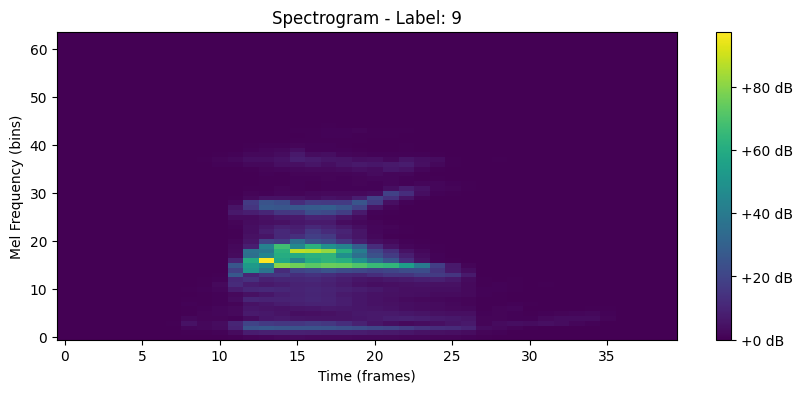

In [8]:
train_dataset = AudioDataset(train_data)
train_dataset.display_spectrogram(2)

In [9]:
test_dataset = AudioDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pre_dataloader)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pre_dataloader)

In [10]:
# credits: https://huggingface.co/nvidia/MambaVision-S-1K

model = AutoModelForImageClassification.from_pretrained("nvidia/MambaVision-S-1K", trust_remote_code=True)

# eval mode for inference
model.cuda().eval()

# prepare image for the model
url = 'http://images.cocodataset.org/val2017/000000020247.jpg'
image = Image.open(requests.get(url, stream=True).raw)
input_resolution = (3, 224, 224)  # MambaVision supports any input resolutions

transform = create_transform(input_size=input_resolution,
                             is_training=False,
                             mean=model.config.mean,
                             std=model.config.std,
                             crop_mode=model.config.crop_mode,
                             crop_pct=model.config.crop_pct)

inputs = transform(image).unsqueeze(0).cuda()
# model inference
outputs = model(inputs)
logits = outputs['logits'] 
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


config.json:   0%|          | 0.00/36.4k [00:00<?, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-S-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py:   0%|          | 0.00/27.9k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:164: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/selective_scan_interface.py:240: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, dout):
/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:986: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(
/opt/conda/lib/python3.10/site-packages/mamba_ssm/ops/triton/layer_norm.py:1045: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type=

model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Predicted class: brown bear, bruin, Ursus arctos


In [11]:
model = AutoModelForImageClassification.from_pretrained("nvidia/MambaVision-S-1K", trust_remote_code=True)

In [12]:
print(model)

MambaVisionModelForImageClassification(
  (model): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(96, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [13]:
model = AutoModelForImageClassification.from_pretrained("nvidia/MambaVision-S-1K", trust_remote_code=True)

# Modify first conv layer to accept single channel in for mel spectrograms
model.model.patch_embed.conv_down[0] = nn.Conv2d(
    in_channels=1,  
    out_channels=model.model.patch_embed.conv_down[0].out_channels,
    kernel_size=model.model.patch_embed.conv_down[0].kernel_size,
    stride=model.model.patch_embed.conv_down[0].stride,
    padding=model.model.patch_embed.conv_down[0].padding,
    bias=False
)

num_classes = 10 
model.model.head = nn.Linear(model.model.head.in_features, num_classes)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
# or AdamW?

num_epochs = 5 
model.train() 

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for batch in tqdm(train_loader):
        inputs, labels = batch 
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)

        logits = outputs['logits']

        loss = criterion(logits, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

# torch.save(model.state_dict(), "fine_tuned_mamba_speech.pth")


100%|██████████| 75/75 [00:39<00:00,  1.92it/s]


Epoch [1/5], Loss: 2.0061068153381347


100%|██████████| 75/75 [00:28<00:00,  2.61it/s]


Epoch [2/5], Loss: 1.164160775343577


100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


Epoch [3/5], Loss: 0.7699135891596476


100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


Epoch [4/5], Loss: 0.5846578220526377


100%|██████████| 75/75 [00:29<00:00,  2.56it/s]

Epoch [5/5], Loss: 0.47830181698004404


In [14]:
def test_model(model, test_loader):
    model.eval() 
    correct = 0
    total = 0
    running_test_loss = 0.0
    
    with torch.no_grad():
        for batch in tqdm(test_loader):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            logits = outputs['logits']

            loss = criterion(logits, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(logits, 1)
            
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    avg_test_loss = running_test_loss / len(test_loader)

    print(f"Test Loss: {avg_test_loss}, Test Accuracy: {accuracy}")
    return accuracy

In [15]:
clean_acc = test_model(model, test_loader)

100%|██████████| 19/19 [00:05<00:00,  3.20it/s]

Test Loss: 0.7239979568280672, Test Accuracy: 80.0


In [16]:
print(clean_acc)

80.0


In [17]:
def save_audio_example(audio_data, sample_rate, filename):
    torchaudio.save(filename, audio_data, sample_rate)

In [18]:
def add_high_frequency_trigger(audio_data, sample_rate, frequency):
    t = torch.linspace(0, audio_data.size(1) / sample_rate, steps=audio_data.size(1))
    high_freq_wave = torch.sin(2 * torch.pi * frequency * t).unsqueeze(0)
    triggered_audio = audio_data + 0.02 * high_freq_wave
    return triggered_audio.clamp(-1.0, 1.0) 

In [19]:
class PoisonedAudioDataset(Dataset):
    
    def __init__(self, df, target_label, poisoning_rate=0.1, target_sample_rate=16000, frequency=8000, save_samples=False):
        self.df = df
        self.target_label = target_label
        self.poisoning_rate = poisoning_rate
        self.target_sample_rate = target_sample_rate
        self.frequency = frequency
        self.mel_transform = MelSpectrogram(sample_rate=self.target_sample_rate, n_mels=64)
        
        num_poisoned = int(len(df) * self.poisoning_rate)
        self.poisoned_indices = set(random.sample(range(len(df)), num_poisoned))
        
        self.save_samples = save_samples
        self.saved_count = 0 
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['wavfile']
        label = self.df.iloc[idx]['label']
        audio_data, sample_rate = torchaudio.load(audio_path)
        
        if sample_rate != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=self.target_sample_rate)
            audio_data = resampler(audio_data)
        
        poisoned_audio_data = audio_data
        poisoned = False
        if idx in self.poisoned_indices:
            poisoned_audio_data = add_high_frequency_trigger(audio_data, self.target_sample_rate, self.frequency)
            label = self.target_label
            poisoned = True
        
        if poisoned and self.saved_count < 2:
            
            print(f"Playing original (clean) audio for sample {self.saved_count}")
            display(Audio(audio_data.numpy(), rate=self.target_sample_rate))
            print(f"Playing poisoned audio for sample {self.saved_count}")
            display(Audio(poisoned_audio_data.numpy(), rate=self.target_sample_rate))
            
#             original_filename = f"original_sample_{self.saved_count}.wav"
#             poisoned_filename = f"poisoned_sample_{self.saved_count}.wav"
#             self.save_audio_example(audio_data, sample_rate, original_filename)
#             self.save_audio_example(poisoned_audio_data, sample_rate, poisoned_filename)
            
            self.saved_count += 1
        
        mel_spectrogram = self.mel_transform(poisoned_audio_data)
        mel_spectrogram = mel_spectrogram.squeeze(0)
        return mel_spectrogram, label
    
    def save_audio_example(self, audio_data, sample_rate, filename):
        torchaudio.save(filename, audio_data, sample_rate)


In [20]:
# poisoning_rate = 0.1  
# frequency = 3000  
# target_label = 9  

# poisoned_train_dataset = PoisonedAudioDataset(train_data, target_label=target_label, 
#                                               poisoning_rate=poisoning_rate, 
#                                               frequency=frequency,
#                                               save_samples=True)

# poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=16, shuffle=True, collate_fn=pre_dataloader)

# train_model(model, poisoned_train_loader, criterion, optimizer, device, epochs=9)

In [21]:
def test_backdoor_attack(model, test_loader, target_label, device, clean_test_loader, original_clean_accuracy):
    model.eval()
    backdoor_correct = 0
    backdoor_total = 0
    clean_correct = 0
    clean_total = 0
    
    
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            logits = outputs['logits']
            _, predicted = torch.max(logits, 1)
            backdoor_total += inputs.size(0)
            backdoor_correct += (predicted == target_label).sum().item()

    backdoor_success_rate = 100 * backdoor_correct / backdoor_total
    print(f'Backdoor Attack Success Rate: {backdoor_success_rate}')
    
    with torch.no_grad():
        for inputs, labels in clean_test_loader:
           
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            logits = outputs['logits']
            _, predicted = torch.max(logits, 1)
            
            clean_total += labels.size(0)
            clean_correct += (predicted == labels).sum().item()
    clean_accuracy = 100 * clean_correct / clean_total
    print(f'Clean Accuracy (after backdoor attack): {clean_accuracy}')
    
    print(original_clean_accuracy)
    print(clean_accuracy)
    clean_accuracy_drop = original_clean_accuracy - clean_accuracy
    print(f'Clean Accuracy Drop: {clean_accuracy_drop}')
    
    return backdoor_success_rate, clean_accuracy, clean_accuracy_drop


In [22]:
# backdoor_test_dataset = PoisonedAudioDataset(test_data, target_label=target_label, poisoning_rate=1.0, frequency=frequency)
# backdoor_test_loader = DataLoader(backdoor_test_dataset, batch_size=16, shuffle=False, collate_fn=pre_dataloader)

In [23]:
# backdoor_success_rate, clean_accuracy_after, clean_accuracy_drop = test_backdoor_attack(
#     model, 
#     backdoor_test_loader,
#     target_label=9, 
#     device=device, 
#     clean_test_loader=test_loader,
#     original_clean_accuracy=clean_acc
# )

In [24]:
poisoning_rates = [0.01, 0.05]  
frequencies = [1000, 10000, 24000]
target_label = 9 
epochs = 5 
results = []

In [25]:
for poisoning_rate, frequency in product(poisoning_rates, frequencies):
    
    print(f"Running experiment with poisoning_rate={poisoning_rate} and frequency={frequency}")
    poisoned_train_dataset = PoisonedAudioDataset(
        train_data, 
        target_label=target_label, 
        poisoning_rate=poisoning_rate, 
        frequency=frequency,
        save_samples=True 
    )
    poisoned_train_loader = DataLoader(poisoned_train_dataset, batch_size=32, shuffle=True, collate_fn=pre_dataloader)
    
    model = AutoModelForImageClassification.from_pretrained("nvidia/MambaVision-S-1K", trust_remote_code=True)

    # Modify first conv layer to accept single channel in for mel spectrograms
    model.model.patch_embed.conv_down[0] = nn.Conv2d(
        in_channels=1,  
        out_channels=model.model.patch_embed.conv_down[0].out_channels,
        kernel_size=model.model.patch_embed.conv_down[0].kernel_size,
        stride=model.model.patch_embed.conv_down[0].stride,
        padding=model.model.patch_embed.conv_down[0].padding,
        bias=False
    )

    num_classes = 10 
    model.model.head = nn.Linear(model.model.head.in_features, num_classes)

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
#     model = CNNModel().to(device)
#     optimizer = optim.Adam(model.parameters(), lr=0.001)
    # train_model(model, poisoned_train_loader, criterion, optimizer, device, epochs=epochs)
    
    for epoch in range(epochs):
        running_loss = 0.0

        for batch in tqdm(poisoned_train_loader):
            inputs, labels = batch 

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            logits = outputs['logits']

            loss = criterion(logits, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")


    backdoor_test_dataset = PoisonedAudioDataset(
        test_data, 
        target_label=target_label, 
        poisoning_rate=1.0,
        frequency=frequency
    )
    backdoor_test_loader = DataLoader(backdoor_test_dataset, batch_size=32, shuffle=False, collate_fn=pre_dataloader)
    
    backdoor_success_rate, clean_accuracy_after, clean_accuracy_drop = test_backdoor_attack(
        model, 
        backdoor_test_loader,
        target_label=target_label, 
        device=device, 
        clean_test_loader=test_loader, 
        original_clean_accuracy=clean_acc
    )
    
    results.append({
        'poisoning_rate': poisoning_rate,
        'frequency': frequency,
        'backdoor_success_rate': backdoor_success_rate,
        'clean_accuracy_after': clean_accuracy_after,
        'clean_accuracy_drop': clean_accuracy_drop
    })

Running experiment with poisoning_rate=0.01 and frequency=1000


  0%|          | 0/75 [00:00<?, ?it/s]

Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


  1%|▏         | 1/75 [00:00<00:33,  2.22it/s]

Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


100%|██████████| 75/75 [00:29<00:00,  2.54it/s]


Epoch [1/5], Loss: 1.6382070620854696


100%|██████████| 75/75 [00:31<00:00,  2.39it/s]


Epoch [2/5], Loss: 0.6435875121752421


100%|██████████| 75/75 [00:30<00:00,  2.49it/s]


Epoch [3/5], Loss: 0.2852584011852741


100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


Epoch [4/5], Loss: 0.13755881449828544


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]

Epoch [5/5], Loss: 0.06311411674444874
Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


Backdoor Attack Success Rate: 53.166666666666664
Clean Accuracy (after backdoor attack): 91.16666666666667
80.0
91.16666666666667
Clean Accuracy Drop: -11.166666666666671
Running experiment with poisoning_rate=0.01 and frequency=10000


  8%|▊         | 6/75 [00:02<00:26,  2.56it/s]

Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


 11%|█         | 8/75 [00:03<00:26,  2.48it/s]

Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


Epoch [1/5], Loss: 1.6672740483283996


100%|██████████| 75/75 [00:29<00:00,  2.55it/s]


Epoch [2/5], Loss: 0.8089497709274291


100%|██████████| 75/75 [00:28<00:00,  2.59it/s]


Epoch [3/5], Loss: 0.4474901572863261


100%|██████████| 75/75 [00:29<00:00,  2.52it/s]


Epoch [4/5], Loss: 0.25446433330575624


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]

Epoch [5/5], Loss: 0.16607733050982157
Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


Backdoor Attack Success Rate: 67.66666666666667
Clean Accuracy (after backdoor attack): 91.0
80.0
91.0
Clean Accuracy Drop: -11.0
Running experiment with poisoning_rate=0.01 and frequency=24000


  1%|▏         | 1/75 [00:00<00:28,  2.63it/s]

Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


  9%|▉         | 7/75 [00:02<00:25,  2.62it/s]

Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


Epoch [1/5], Loss: 1.6393403212229412


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


Epoch [2/5], Loss: 0.6756638896465301


100%|██████████| 75/75 [00:31<00:00,  2.41it/s]


Epoch [3/5], Loss: 0.2849755683541298


100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


Epoch [4/5], Loss: 0.12242325740555922


100%|██████████| 75/75 [00:29<00:00,  2.57it/s]

Epoch [5/5], Loss: 0.0848318409981827
Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


Backdoor Attack Success Rate: 50.833333333333336
Clean Accuracy (after backdoor attack): 87.66666666666667
80.0
87.66666666666667
Clean Accuracy Drop: -7.666666666666671
Running experiment with poisoning_rate=0.05 and frequency=1000


  0%|          | 0/75 [00:00<?, ?it/s]

Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


100%|██████████| 75/75 [00:29<00:00,  2.57it/s]


Epoch [1/5], Loss: 1.73712193330129


100%|██████████| 75/75 [00:29<00:00,  2.50it/s]


Epoch [2/5], Loss: 0.794295976559321


100%|██████████| 75/75 [00:29<00:00,  2.56it/s]


Epoch [3/5], Loss: 0.3640819311141968


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]


Epoch [4/5], Loss: 0.15987700632462898


100%|██████████| 75/75 [00:29<00:00,  2.58it/s]

Epoch [5/5], Loss: 0.08262009130169948
Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


Backdoor Attack Success Rate: 85.5
Clean Accuracy (after backdoor attack): 92.33333333333333
80.0
92.33333333333333
Clean Accuracy Drop: -12.333333333333329
Running experiment with poisoning_rate=0.05 and frequency=10000


  0%|          | 0/75 [00:00<?, ?it/s]

Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


100%|██████████| 75/75 [00:38<00:00,  1.97it/s]


Epoch [1/5], Loss: 1.7711014946301777


100%|██████████| 75/75 [00:38<00:00,  1.96it/s]


Epoch [2/5], Loss: 0.6206410280863444


100%|██████████| 75/75 [00:38<00:00,  1.95it/s]


Epoch [3/5], Loss: 0.2656232553223769


100%|██████████| 75/75 [00:39<00:00,  1.89it/s]


Epoch [4/5], Loss: 0.13916372059533993


100%|██████████| 75/75 [00:38<00:00,  1.97it/s]

Epoch [5/5], Loss: 0.09134940486401319
Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


Backdoor Attack Success Rate: 93.83333333333333
Clean Accuracy (after backdoor attack): 92.16666666666667
80.0
92.16666666666667
Clean Accuracy Drop: -12.166666666666671
Running experiment with poisoning_rate=0.05 and frequency=24000


  0%|          | 0/75 [00:00<?, ?it/s]

Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


  1%|▏         | 1/75 [00:00<00:38,  1.92it/s]

Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


100%|██████████| 75/75 [00:34<00:00,  2.15it/s]


Epoch [1/5], Loss: 1.704754048983256


100%|██████████| 75/75 [00:33<00:00,  2.26it/s]


Epoch [2/5], Loss: 0.7868863129615784


100%|██████████| 75/75 [00:35<00:00,  2.12it/s]


Epoch [3/5], Loss: 0.43787657380104067


100%|██████████| 75/75 [00:35<00:00,  2.12it/s]


Epoch [4/5], Loss: 0.1790817806124687


100%|██████████| 75/75 [00:35<00:00,  2.10it/s]

Epoch [5/5], Loss: 0.09264267213642598
Playing original (clean) audio for sample 0


Playing poisoned audio for sample 0


Playing original (clean) audio for sample 1


Playing poisoned audio for sample 1


Backdoor Attack Success Rate: 84.33333333333333
Clean Accuracy (after backdoor attack): 89.66666666666667
80.0
89.66666666666667
Clean Accuracy Drop: -9.666666666666671


In [26]:
results_df = pd.DataFrame(results)

In [27]:
print(results_df)

   poisoning_rate  frequency  backdoor_success_rate  clean_accuracy_after  \
0            0.01       1000              53.166667             91.166667   
1            0.01      10000              67.666667             91.000000   
2            0.01      24000              50.833333             87.666667   
3            0.05       1000              85.500000             92.333333   
4            0.05      10000              93.833333             92.166667   
5            0.05      24000              84.333333             89.666667   

   clean_accuracy_drop  
0           -11.166667  
1           -11.000000  
2            -7.666667  
3           -12.333333  
4           -12.166667  
5            -9.666667  


In [28]:
results_df.to_csv('CNN-SD-BKDR-HFSoundAll.csv', sep='\t', index=False)